# <a>Introduction</a>  


# <a>Import</a>  

In [12]:
import numpy as np
from matplotlib import pyplot as plt 
import cv2
import os
from itertools import combinations

# <a>Preprocess</a>  

In [13]:
def _find_lowest_manhattan_distance(points):
    # Generate all combinations of 3 points
    all_combinations = combinations(points, 3)
    min_distance = float('inf')
    best_combination = None

    for combo in all_combinations:
        # Calculate the total Manhattan distance between the 3 points
        distance = sum(
            abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
            for i, p1 in enumerate(combo)
            for p2 in combo[i + 1:]
        )
        if distance < min_distance:
            min_distance = distance
            best_combination = combo

    return best_combination

In [14]:
class PROIE():
    def __init__(self):
        pass

    def _threshold(self):
        self.blur_img = cv2.GaussianBlur(self.in_img_g, (5, 5), 0)
        # apply for black background image
        _, self.thresh_img = cv2.threshold(self.blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    def _contours(self):
        self.contours, _ = cv2.findContours(self.thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if len(self.contours) > 0:
            self.contours = max(self.contours, key=cv2.contourArea)
        self.contour_img = self.in_img_c.copy()
        self.contour_img = cv2.drawContours(self.contour_img, [self.contours], 0, (255, 0, 0), 2)

    def _landmarks(self, edge_threshold = 20):
        M = cv2.moments(self.thresh_img)
        x_c = M['m10'] // M['m00']
        y_c = M['m01'] // M['m00']
        self.center_point = {"x": x_c, "y": y_c}
        self.contours = self.contours.reshape(-1, 2)
        left_id = np.argmin(self.contours.sum(-1))
        self.contours = np.concatenate(
            [self.contours[left_id:, :], self.contours[:left_id, :]]
        )
        dist_c = np.sqrt(
            np.square(self.contours - [self.center_point["x"], self.center_point["y"]]).sum(-1)
        )
        f = np.fft.rfft(dist_c)
        cutoff = 15
        f_new = np.concatenate([f[:cutoff], 0 * f[cutoff:]])
        dist_c_1 = np.fft.irfft(f_new)
        derivative = np.diff(dist_c_1)
        sign_change = np.diff(np.sign(derivative)) / 2
        self.landmarks = {"x": [], "y": []}

        # Filter landmarks based on edge threshold
        height, width = self.thresh_img.shape[:2]
        for landmark in self.contours[np.where(sign_change > 0)[0]]:
            if (
                edge_threshold <= landmark[0] <= width - edge_threshold
                and edge_threshold <= landmark[1] <= height - edge_threshold
            ):
                self.landmarks["x"].append(landmark[0])
                self.landmarks["y"].append(landmark[1])

    def _landmarks_select(self):
        y_rank = np.array(np.argsort(self.landmarks["y"]))
        self.landmarks_selected = {
            "x": np.array(self.landmarks["x"])[y_rank][:4],
            "y": np.array(self.landmarks["y"])[y_rank][:4]
        }

        points = list(zip(self.landmarks_selected["x"], self.landmarks_selected["y"]))

        best_combination = _find_lowest_manhattan_distance(points)

        best_combination = np.array(best_combination)
        x_vals = best_combination[:, 0]
        y_vals = best_combination[:, 1]

        min_x_index = np.argmin(x_vals)
        max_x_index = np.argmax(x_vals)

        self.landmarks_selected = {
            "x": np.array([x_vals[min_x_index], x_vals[max_x_index]]),
            "y": np.array([y_vals[min_x_index], y_vals[max_x_index]])
        }
        
    def _alignement(self):
        h, w = self.in_img_g.shape
        theta = np.arctan2((self.landmarks_selected["y"][1] - self.landmarks_selected["y"][0]), (
            self.landmarks_selected["x"][1] - self.landmarks_selected["x"][0]))*180/np.pi
        R = cv2.getRotationMatrix2D(
            (int(self.landmarks_selected["x"][1]), int(self.landmarks_selected["y"][1])), theta, 1)
        self.align_img = cv2.warpAffine(self.in_img_g, R, (w, h))

        point_1 = [self.landmarks_selected["x"]
                   [0], self.landmarks_selected["y"][0]]
        point_2 = [self.landmarks_selected["x"]
                   [1], self.landmarks_selected["y"][1]]

        point_1 = (R[:, :2] @ point_1 + R[:, -1]).astype(int)
        point_2 = (R[:, :2] @ point_2 + R[:, -1]).astype(int)

        self.landmarks_selected_align = {
            "x": [point_1[0], point_2[0]], "y": [point_1[1], point_2[1]]}

    def _roi_extract(self, margin = 20):
        point_1 = np.array([self.landmarks_selected_align["x"]
                            [0], self.landmarks_selected_align["y"][0]])
        point_2 = np.array([self.landmarks_selected_align["x"]
                            [1], self.landmarks_selected_align["y"][1]])

        self.ux = max(0, point_1[0] - margin) 
        self.uy = max(0, point_1[1] + (point_2 - point_1)[0] // 3 - margin)
        self.lx = min(self.align_img.shape[1], point_2[0] + margin) 
        self.ly = min(self.align_img.shape[0], point_2[1] + 4 * (point_2 - point_1)[0] // 3 + margin)


        self.roi_zone_img = cv2.cvtColor(self.align_img, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(self.roi_zone_img, (self.lx, self.ly),(self.ux, self.uy), (0, 255, 0), 2)

        self.roi_img = self.align_img[self.uy:self.ly, self.ux:self.lx]


    def extract_roi(self, path_in_img, rotate=False):
        self.in_img_c = cv2.imread(path_in_img)
        if(rotate):
            self.in_img_c = cv2.rotate(self.in_img_c, cv2.ROTATE_90_CLOCKWISE)

        if len(self.in_img_c.shape) == 3:
            self.in_img_g = cv2.cvtColor(self.in_img_c, cv2.COLOR_BGR2GRAY)
        else:
            self.in_img_g = self.in_img_c

        self._threshold()
        self._contours()
        self._landmarks()
        self._landmarks_select()
        self._alignement()
        self._roi_extract()

    def save(self, path_out_img):
        cv2.imwrite(path_out_img, self.roi_img)

    def show_result(self):
        plt.figure(figsize=(16, 10))

        plt.subplot(241)
        plt.imshow(self.in_img_g, cmap="gray")
        plt.title("Original")

        plt.subplot(242)
        plt.imshow(self.thresh_img, cmap="gray")
        plt.title("Threshold (OTSU)")

        plt.subplot(243)
        plt.imshow(self.contour_img, cmap="gray")
        plt.plot(self.center_point["x"], self.center_point["y"], 'bx')
        plt.title("Contours")

        plt.subplot(244)
        plt.imshow(self.in_img_c, cmap="gray")
        for idx in range(len(self.landmarks["x"])):
            plt.plot(self.landmarks["x"][idx], self.landmarks["y"][idx], 'rx')
        plt.title("Landmarks")

        plt.subplot(245)
        plt.imshow(self.in_img_c, cmap="gray")
        plt.plot(self.landmarks_selected["x"][0],
                 self.landmarks_selected["y"][0], 'rx')
        plt.plot(self.landmarks_selected["x"][1],
                 self.landmarks_selected["y"][1], 'rx')
        plt.title("Selected")

        plt.subplot(246)
        plt.imshow(self.align_img, cmap="gray")
        plt.plot(self.landmarks_selected_align["x"][0],
                 self.landmarks_selected_align["y"][0], 'rx')
        plt.plot(self.landmarks_selected_align["x"][1],
                 self.landmarks_selected_align["y"][1], 'rx')
        plt.title("Alignment")

        plt.subplot(247)
        plt.imshow(self.roi_zone_img, cmap="gray")
        plt.title("ROI")

        plt.subplot(248)
        plt.imshow(self.roi_img, cmap="gray")
        plt.title("Extraction")

        plt.show()

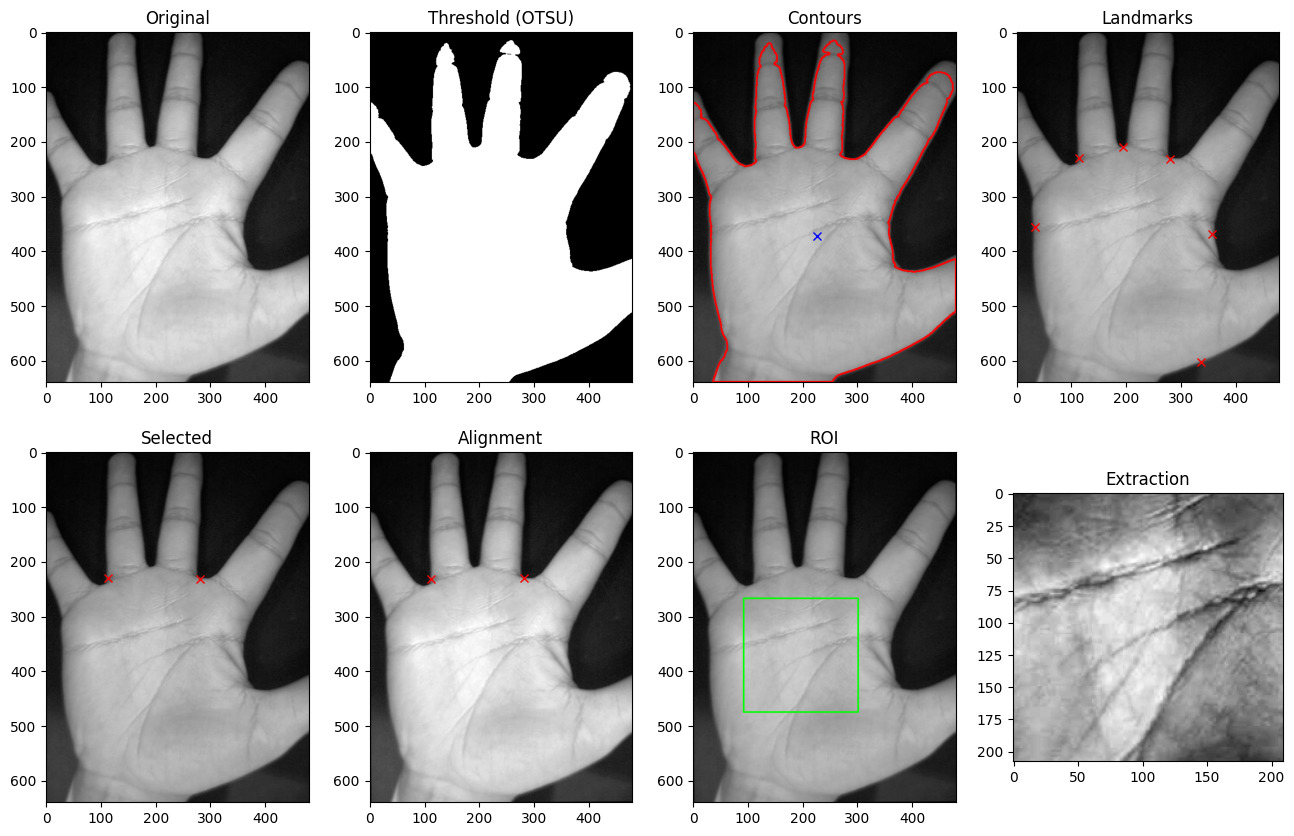

In [16]:
proie = PROIE()

# for i in range (1, 2):
#     img = f"img/0001/0001_m_l_0{i}.jpg"
#     proie.extract_roi(img, rotate=True)
#     proie.show_result()

img = f"CASIA-PalmprintV1/0109/0109_f_r_05.jpg"
proie.extract_roi(img, rotate=True)
proie.show_result()

In [ ]:
proie = PROIE()

img = f"0004_m_l_05.jpg"
proie.extract_roi(img, rotate=True)
proie.show_result()

In [ ]:
proie = PROIE()

input_root = "./CASIA-PalmprintV1"  
output_root = "roi_ver2_full"  
error_log_path = "errors.txt"

os.makedirs(output_root, exist_ok=True)

# Initialize counters
total_images = 0
error_images = 0

# Open the error log file for writing
with open(error_log_path, "w") as error_log:
    for subfolder in sorted(os.listdir(input_root)):
        
        subfolder_path = os.path.join(input_root, subfolder)
        
        if not os.path.isdir(subfolder_path):
            continue

        output_subfolder = os.path.join(output_root, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)

        for filename in sorted(os.listdir(subfolder_path)):
            if filename.lower().endswith('.jpg'):
                total_images += 1
                input_image_path = os.path.join(subfolder_path, filename)
                output_image_path = os.path.join(
                    output_subfolder, f"{os.path.splitext(filename)[0]}_roi.jpg"
                )

                try:
                    proie.extract_roi(input_image_path, rotate=True)
                    proie.save(output_image_path)
                except (IndexError, ValueError) as e:
                    # Write the error to the log file
                    error_log.write(f"{input_image_path}: {type(e).__name__} - {e}\n")
                    
                    # Increment the error count
                    error_images += 1

# Print the result at the end
print(f"Total images processed: {total_images}")
print(f"Total images with errors: {error_images}")
print(f"Error rate: {error_images / total_images * 100:.2f}%")


KeyboardInterrupt: 